# Problème n°2: PointNet

Certains jeux de données impliquent des nuages de points dans un espace 3D. Penser par exemple à un ensemble de mesures lidar : chaque tir permet de renseigner les coordonnées d'un des points de l'objet ciblé.
Une tâche intéressante consiste à classer chacun des points du nuage en fonction de l'objet auquel il appartient. Cette tâche est considérée comme une variante de la segmentation sémantique d'images.

Ce problème introduit à une méthode directe de segmentation d'un nuage par deep learning. Elle est basée sur une architecture particulière appelée PointNet. \
Dans la première partie, on présente un jeu de données (synthétisé à la volée) impliquant des nuages de points.
Dans la seconde partie, on explore la structure et les propriétés de PointNet. Dans la troisième, on l'entraîne et dans la dernière partie, on charge les poids d'une version améliorée de PointNet (PointNet++) pour comparaison.

La cellule suivante permet les imports nécessaires:

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.pyplot as plt
import os
! pip install einops
! git clone https://github.com/emiledevos/exam_2025.git
! cp exam_2025/utils/utils_probleme2.py .
from utils_probleme2 import gen_pointcloud, plot_triplets

Cloning into 'exam_2025'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 63 (delta 4), reused 3 (delta 3), pack-reused 52 (from 1)
Receiving objects: 100% (63/63), 1.94 MiB | 22.04 MiB/s, done.
Resolving deltas: 100% (17/17), done.


## Partie I : un exemple de PointCLoud data

Pour construire le jeu de données, on simule un terrain couvert de deux types de bâtiments : des immeubles de forme rectangulaire aux toits plats et des igloos (dômes). Pour créer les nuages, on échantillonne les surfaces vues du ciel (les murs des bâtiments rectangulaires ne sont pas échantillonnées), en favorisant les zones d'altitude non nulles.
Le but est de distinguer les igloos du reste (sol et toits des bâtiments). Il s'agit donc d'une segmentation binaire.

0


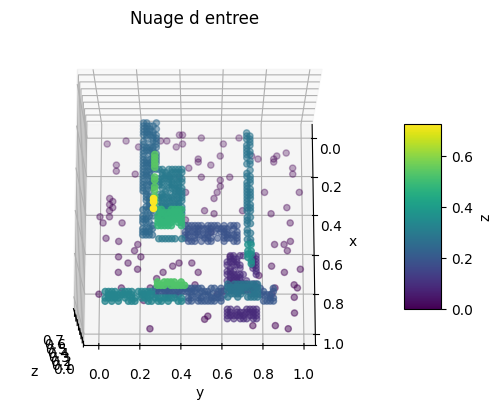

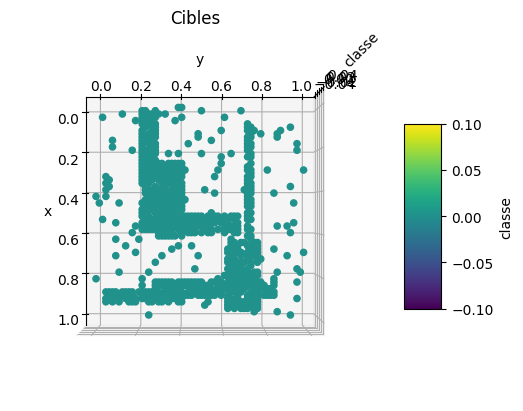

1


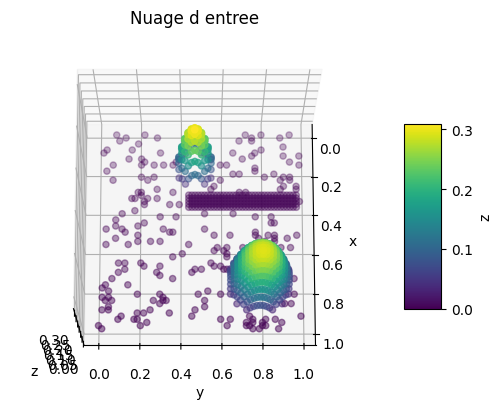

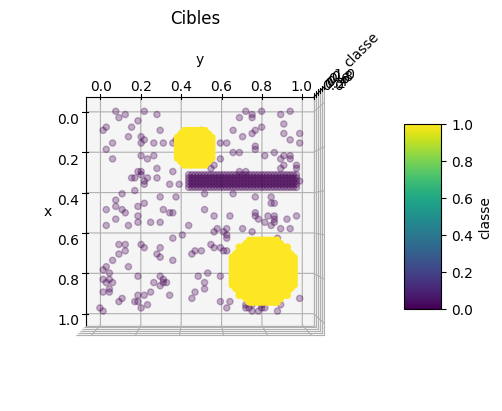

2


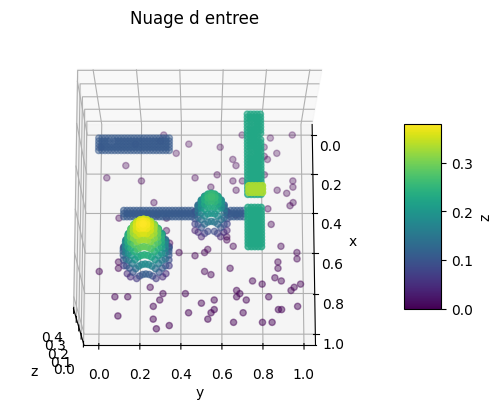

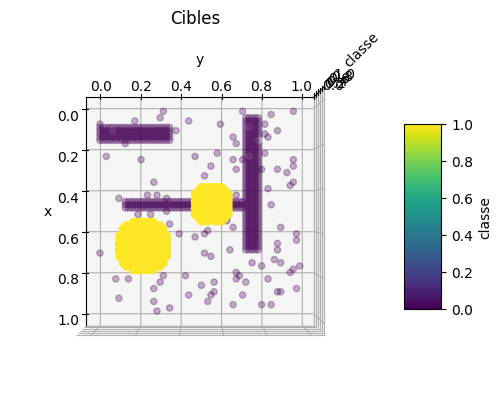

3


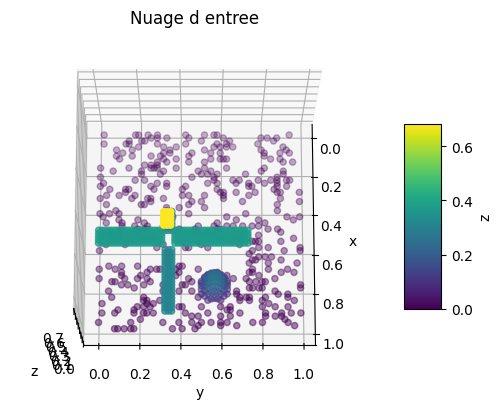

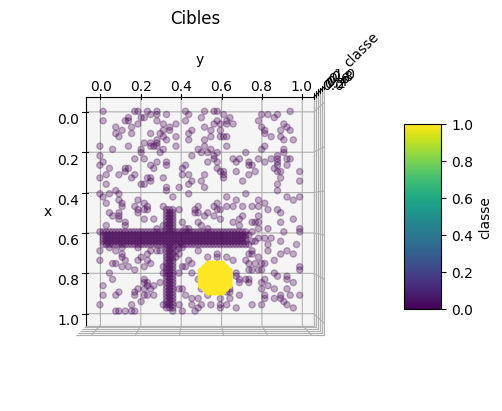

4


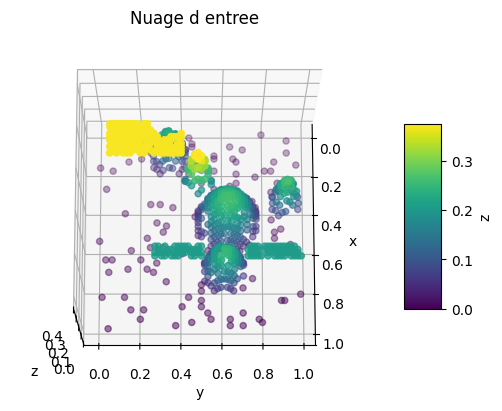

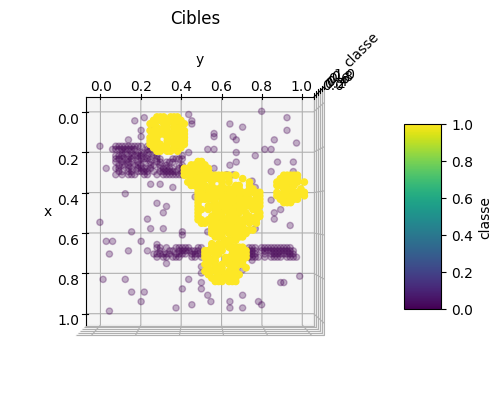

5


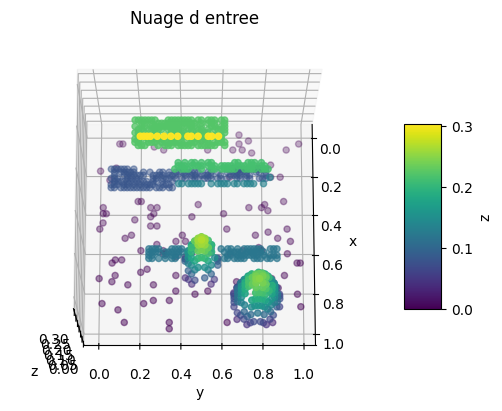

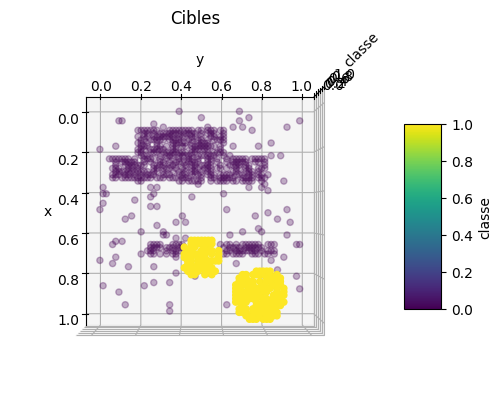

In [4]:
batch_size = 6
input_points, target_list, target_points  = gen_pointcloud(batch_size)


for i in range(batch_size):
  print(i)
  # Représentation 3D des nuages de points et
  # les paramètres elev et azim permettent de changer l'angle de vue
  plot_triplets(input_points[i].transpose(0,1).cpu(),
                elev=75, azim=0)

  # Cibles : les points appartenant aux toitures d'igloos sont
  # dans la classe 1, les autres, dans la classe 0.
  plot_triplets(target_points[i].transpose(0,1).cpu(),
                title='Cibles',
                cbar_label='classe')

  # Note: target_points contient non seulement les classes
  # mais aussi les coordonnées x et y des points, pour
  # faciliter leur visualisation



**Q1** A quoi correspondent les différentes dimensions de *input_points* ?

la premiere dimenssion represente la taille du batch size. ici ça vaut 6, ça veut dire qu'il y a 6 nuages de point par batch

la deuxieme dimenssion est le nombre de point qu'il y a dans chaque nuages de point

Enfin, la troisieme dimension est les coordonées x,y,z de chaque point. comme il y a donc 3 dimension, cette valeur vaut 3.

Le code çi dessous nous le confirme.

In [5]:
input_points.shape

torch.Size([6, 3, 800])

**Q2** Les points d'un nuage sont-ils rangés dans un ordre particulier ?

NOn il ne sont pas rangé dans un ordre particulier, mais bien dans un ordre arbitraire, car ils sont échantillonés sans ordre particulier.

**Q3** (question ouverte). Si vous deviez traiter le problème avec un FCN ou un ViT (Visual Transformer), que feriez-vous ?

Je ferai unr projection dans le plan 2D de mes valeurs. Je donnerai a chaque point une "altitude" qui serait donc le z. à partir de cela, le probleme reviendrait a analyser une image avec finalement un seul canal de couleur, ce que a priori un fcn ou un VIT est capable de faire.

## Partie II : le modèle PointNet

Dans cette partie, on s'intéresse à la propriété principale d'un réseau PointNet : l'utilisation d'opérations invariantes par rapport à l'ordre dans lequel les points sont présentés au réseau.

In [6]:
from utils_probleme2 import PointNetSegHead
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
output, _, _ = pointnet(input_points)

**Q1** La sortie du modèle PointNet correspond au premier tenseur du *tuple* fourni la fonction *forward* de *pointnet*. A quoi correspondent les différentes dimensions de *output* ? Quel est l'effet d'une permutation des points contenus dans *inputs_points* sur la sortie ? Répondre :

- en vous référant à l'article [l'article](https://arxiv.org/abs/1612.00593) qui introduit ce réseau (citer dans le texte).
- à partir de tests à effectuer dans la cellule de code suivante (utiliser torch.randperm pour générer des permutations sur les entrées)

#Réponse
Signification des outputs : La premiere composante correspond au batch_size
la seconde composante corresponad au nombre de point par nuage de point.
Enfin la troisième composante est le nombre de classe (ici 2 pour igloo vs reste)

invariance des points:
 "In this paper, we design anovel type of neural network that directly consumes pointclouds, which well respects the permutation invariance of points in the input. "
 une permutation de point ne devrait donc rien changé au résultat finale. on voit avec le code ci dessous que la difference est toujours très faible

In [15]:
import torch

# Générer une permutation aléatoire des indices des points
idx = torch.randperm(input_points.shape[1])

# Appliquer la permutation aux points d'entrée
permuted_input = input_points[:, idx, :]
ouput= pointnet(input_points)
# Calculer la sortie avec les points permutés
permuted_output, _, _ = pointnet(permuted_input)

# Comparer la sortie originale et la sortie permutée
# (par exemple, en calculant la différence absolue moyenne)
diff = torch.mean(torch.abs(output - permuted_output))
print(diff)

tensor(0.4418, device='cuda:0', grad_fn=<MeanBackward0>)


**Q2** L'architecture de *pointnet* est décrite dans la Figure 2 de l'article (voir ci-dessous) évoqué à la question précédente. En dehors des opérations notées "input transform" et "feature transform", dont la compréhension est plus délicate, quelles sont les différentes opérations conduisant à une segmentation ? Que signifie le terme "shared" et expliquer en quoi ces opérations sont invariantes par rapport à l'ordre de présentation des points.

<img src= https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lFnrIqmV_47iRvQcY3dB7Q.png >

#Reponse:



## Partie III

Dans cette partie, on se propose d'entraîner un PointNet. Pour ce faire, on utilisera une fonction de coût spécifique (voir cellule ci-dessous).

**Consignes :**

1) Entraîner un PointNet sur quelques centaines d'époques.

2) Afficher à chaque époque la justesse des prédictions

3) Charger les poids d'un réseau entraîné sur 500 époques, stockés dans le fichier **pointnet_500_ep.pth** du répertoire https://huggingface.co/nanopiero/pointnet_igloos.

Visualiser les sorties de ce modèle-là en complétant le la dernière cellule de code du calepin.


In [24]:
import torch
import torch.nn as nn


optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.0001, betas=(0.9, 0.999))

loss_fn = nn.CrossEntropyLoss().cuda()


In [25]:
batch_size = 64
n_epochs = 200
n_batch_per_epoch = 10


for epoch in range(1, n_epochs):
  print('epoch : ', epoch)
  for batch in range(1,n_batch_per_epoch):
    # Générer des données d'entraînement
        input_points, target_list, _ = gen_pointcloud(batch_size)
        input_points = input_points.cuda()
        target_list = target_list.cuda()

        # Calculer les prédictions
        outputs, _, _ = pointnet(input_points)
        # Transposer les sorties pour CrossEntropyLoss
        outputs = outputs.transpose(1, 2)

        # Calculer la perte
        loss = loss_fn(outputs, target_list)

        # Mettre à jour les poids du modèle
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculer et afficher la justesse (accuracy) à la fin de chaque époque
        with torch.no_grad():
          input_points, target_list, _ = gen_pointcloud(batch_size)
          input_points = input_points.cuda()
          target_list = target_list.cuda()
          outputs, _, _ = pointnet(input_points)
          outputs = outputs.transpose(1, 2)
          _, pred_list = torch.max(outputs, 1)  # Obtenir les prédictions
          accuracy = (pred_list == target_list).float().mean().item()
          print(f'Accuracy: {accuracy}')

epoch :  1
Accuracy: 0.48298826813697815
Accuracy: 0.4866601526737213
Accuracy: 0.4415820240974426
Accuracy: 0.47783201932907104
Accuracy: 0.4776953160762787
Accuracy: 0.5071874856948853
Accuracy: 0.4367968738079071
Accuracy: 0.5074609518051147
Accuracy: 0.49169921875
epoch :  2
Accuracy: 0.51220703125
Accuracy: 0.4755273461341858
Accuracy: 0.42640623450279236
Accuracy: 0.5048632621765137
Accuracy: 0.5018163919448853
Accuracy: 0.5238866806030273
Accuracy: 0.49953123927116394
Accuracy: 0.5203320384025574
Accuracy: 0.48689451813697815
epoch :  3
Accuracy: 0.5213476419448853
Accuracy: 0.5005468726158142
Accuracy: 0.5329492092132568
Accuracy: 0.5298046469688416
Accuracy: 0.48726561665534973
Accuracy: 0.49937498569488525
Accuracy: 0.5459570288658142
Accuracy: 0.477851539850235
Accuracy: 0.5216211080551147
epoch :  4
Accuracy: 0.48976561427116394
Accuracy: 0.48656249046325684
Accuracy: 0.4857812523841858
Accuracy: 0.4677148461341858
Accuracy: 0.514941394329071
Accuracy: 0.48876953125
Accurac

KeyboardInterrupt: 

#Commentaire:
On voit que notre boucle d'apprentissage fonctionne et que la précisions augmente au fur et a mesure, par manque de temps je ne peux pas laisser tourner le code jusqu'au bout, mais on a deja pris 20% de precisions en 70 epoch. on peut donc imaginer qu'avec 130 epoch de plus, ça sera encore mieux.

Accuracy: 0.9670833349227905
0


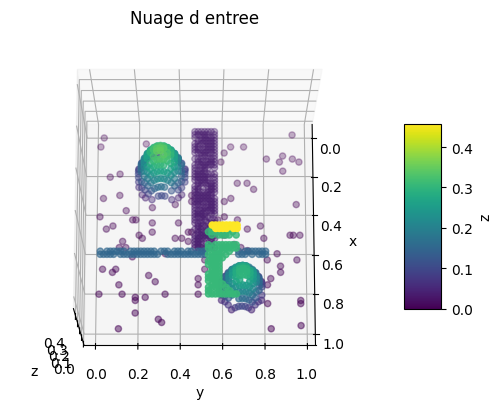

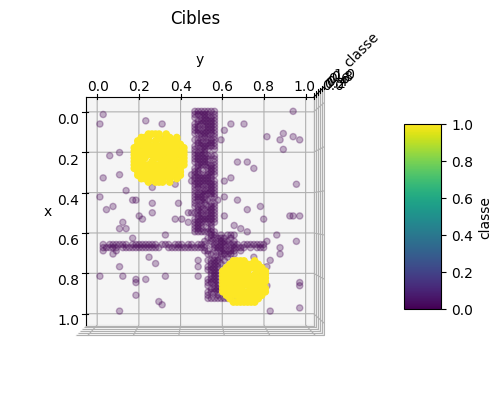

TypeError: zip() argument after * must be an iterable, not ellipsis

In [32]:
input_points, target_list , target_points = gen_pointcloud(6)

# Il faut construire les prédictions.
proba_pred_list, _, _ = pointnet2.cuda()(input_points.to(device))
pred_list = proba_pred_list.transpose(1,2).max(1)[1].cpu()

# Accuracy:
accuracy = (pred_list == target_list.cpu()).float().mean().item()
print(f'Accuracy: {accuracy}')
# Tracé

for i in range(6):
  print(i)
  plot_triplets(input_points[i].transpose(0,1), elev=75, azim=0)
  plot_triplets(target_points[i].transpose(0,1),
                title='Cibles',
                cbar_label='classe')
  plot_triplets(...,
                title='Predictions',
                cbar_label='classe')


Accuracy: 0.9710416793823242
0


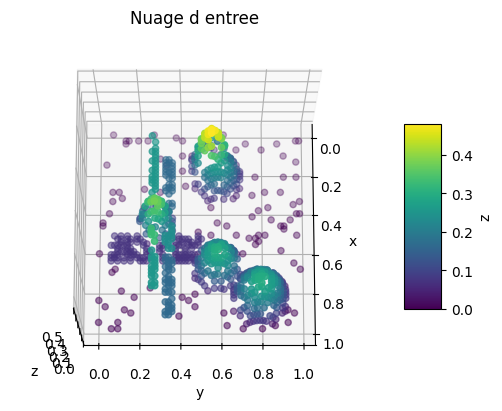

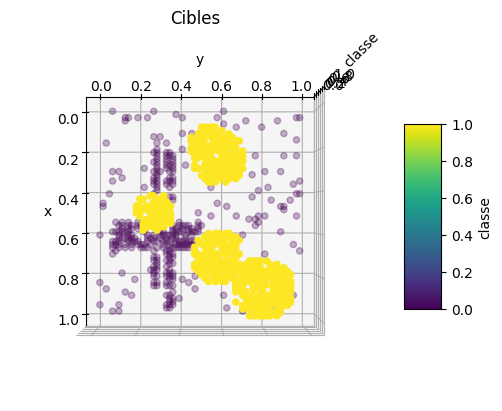

TypeError: zip() argument after * must be an iterable, not ellipsis

In [33]:
import torch

# Charger les poids pré-entraînés
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pointnet2 = PointNetSegHead(num_points=800, num_global_feats=1024, m=2)
pointnet2.load_state_dict(torch.hub.load_state_dict_from_url(
    "https://huggingface.co/nanopiero/pointnet_igloos/resolve/main/pointnet_500_ep.pth",
    map_location=device
))
pointnet2.to(device)
pointnet2.eval()  # Mettre le modèle en mode évaluation

# Générer des données pour la visualisation
input_points, target_list, target_points = gen_pointcloud(6)
input_points = input_points.to(device)

# Calculer les prédictions
proba_pred_list, _, _ = pointnet2(input_points)
pred_list = proba_pred_list.transpose(1, 2).max(1)[1].cpu()

# Calculer et afficher l'accuracy
accuracy = (pred_list == target_list.cpu()).float().mean().item()
print(f'Accuracy: {accuracy}')

# Visualiser les prédictions
for i in range(6):
  print(i)
  plot_triplets(input_points[i].transpose(0,1).cpu(), elev=75, azim=0) #Fixed indentation, and added .cpu() as plot_triplets expects cpu tensors
  plot_triplets(target_points[i].transpose(0,1).cpu(), #Fixed indentation, and added .cpu() as plot_triplets expects cpu tensors
                title='Cibles',
                cbar_label='classe')
  plot_triplets(..., #Fixed indentation
                title='Predictions',
                cbar_label='classe')